
Step 1: Loading CSV files with sampling to avoid memory issues...
Found 169 CSV files.
Data loaded. Shape after sampling and cleaning: (4668657, 47)
Labels mapped. Unique classes: ['Attack' 'Benign']

=== Class Distribution ===
Attack: 4554468
Benign: 110410

Normal (Benign): 110410
Total Attacks  : 4554468
Training LightGBM model for binary classification...
[LightGBM] [Info] Number of positive: 88328, number of negative: 3643574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.257422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5289
[LightGBM] [Info] Number of data points in the train set: 3731902, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023668 -> initscore=-3.719663
[LightGBM] [Info] Start training from score -3.719663
Training until validation scores don't improve for 20 rounds
[50]	training'

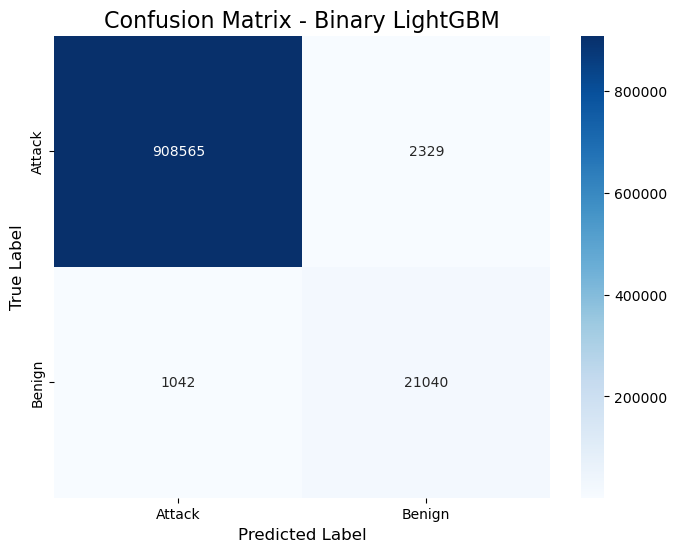


Top 20 important features:
1. rst_count: 4208352.4811
2. urg_count: 1042467.3884
3. IAT: 336630.0086
4. Rate: 202770.7528
5. flow_duration: 189507.7042
6. Number: 74920.5531
7. Header_Length: 70688.6611
8. HTTP: 49985.3448
9. Weight: 35390.6792
10. syn_count: 28743.8812
11. Tot size: 28711.8921
12. Variance: 19827.8175
13. Protocol Type: 19603.5150
14. fin_count: 19152.7443
15. Srate: 18882.8756
16. ack_count: 18529.8499
17. Duration: 18253.3736
18. Magnitue: 17366.8425
19. HTTPS: 10957.0114
20. AVG: 10507.7676


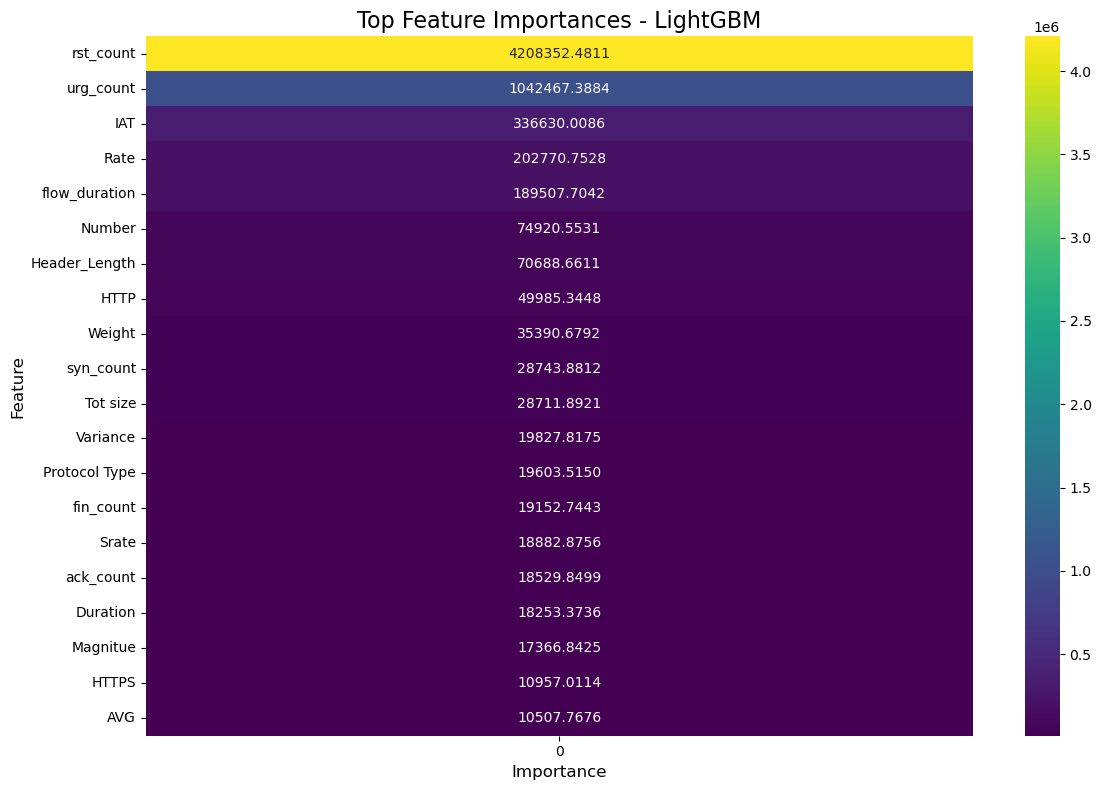

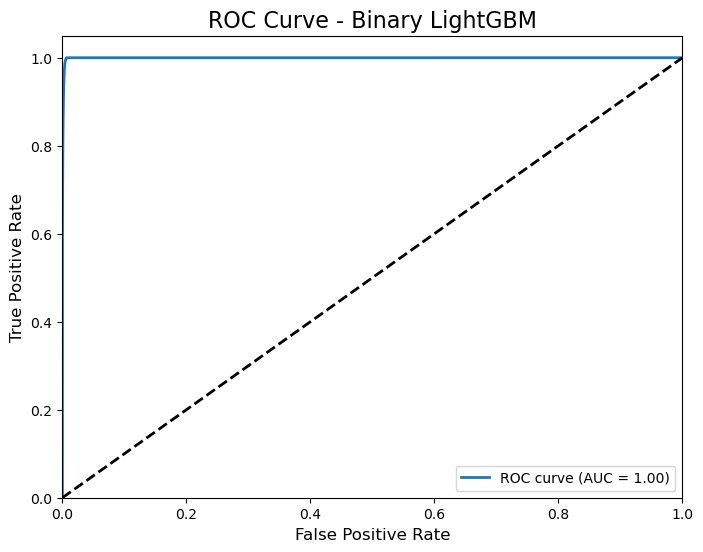

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score,
    recall_score, precision_score, log_loss, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb


RANDOM_STATE = 42
DATASET_PATH = '/Users/bodapati/Downloads/wataiData 3/csv/CICIoT2023'
SAMPLING_FRACTION = 0.1  
TOP_N_FEATURES = 20


def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

# --- STEP 1: LOAD & SAMPLE CSVs ---
print("\nStep 1: Loading CSV files with sampling to avoid memory issues...")
all_files = glob.glob(os.path.join(DATASET_PATH, "*.csv"))
if not all_files:
    raise FileNotFoundError(f"No CSV files found in {DATASET_PATH}")
print(f"Found {len(all_files)} CSV files.")

df_list = []
for file in all_files:
    df = pd.read_csv(file).sample(frac=SAMPLING_FRACTION, random_state=RANDOM_STATE)
    df_list.append(df)
main_df = pd.concat(df_list, ignore_index=True)
main_df.dropna(axis=1, how='all', inplace=True)
main_df.dropna(inplace=True)
main_df.drop_duplicates(inplace=True)
print(f"Data loaded. Shape after sampling and cleaning: {main_df.shape}")

# --- STEP 2: BINARY LABEL MAPPING ---
category_map = {
    "BenignTraffic": "Benign",
    "DDoS-ACK_Fragmentation": "Attack", "DDoS-HTTP_Flood": "Attack", "DDoS-ICMP_Flood": "Attack",
    "DDoS-ICMP_Fragmentation": "Attack", "DDoS-PSHACK_Flood": "Attack", "DDoS-RSTFINFlood": "Attack",
    "DDoS-SlowLoris": "Attack", "DDoS-SYN_Flood": "Attack", "DDoS-SynonymousIP_Flood": "Attack",
    "DDoS-TCP_Flood": "Attack", "DDoS-UDP_Flood": "Attack", "DDoS-UDP_Fragmentation": "Attack",
    "DoS-TCP_Flood": "Attack", "DoS-SYN_Flood": "Attack", "DoS-UDP_Flood": "Attack", "DoS-HTTP_Flood": "Attack",
    "Recon-PingSweep": "Attack", "Recon-OSScan": "Attack", "Recon-VulnerabilityScan": "Attack",
    "Recon-PortScan": "Attack", "Recon-HostDiscovery": "Attack",
    "SqlInjection": "Attack", "CommandInjection": "Attack", "Backdoor_Malware": "Attack",
    "Uploading_Attack": "Attack", "XSS": "Attack", "BrowserHijacking": "Attack",
    "DictionaryBruteForce": "Attack",
    "MITM-ArpSpoofing": "Attack", "DNS_Spoofing": "Attack",
    "Mirai-greip_flood": "Attack", "Mirai-greeth_flood": "Attack", "Mirai-udpplain": "Attack"
}
main_df['label'] = main_df['label'].map(category_map)
main_df.dropna(subset=['label'], inplace=True)
print(f"Labels mapped. Unique classes: {main_df['label'].unique()}")


print("\n=== Class Distribution ===")
for label, count in main_df['label'].value_counts().items():
    print(f"{label}: {count}")

normal_count = main_df[main_df['label'] == 'Benign'].shape[0]
attack_count = main_df[main_df['label'] == 'Attack'].shape[0]
print(f"\nNormal (Benign): {normal_count}")
print(f"Total Attacks  : {attack_count}")



# --- STEP 4: TRAIN-TEST SPLIT & FEATURE SCALING ---
cols_to_drop = ['label', 'device', 'device_category', 'ts']
existing_cols_to_drop = [col for col in cols_to_drop if col in main_df.columns]

X = main_df.drop(columns=existing_cols_to_drop).select_dtypes(include=np.number)
y = main_df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Benign: 0, Attack: 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- STEP 5: TRAIN LIGHTGBM ---
print("Training LightGBM model for binary classification...")
lgb_train = lgb.Dataset(X_train_scaled, label=y_train)
lgb_test = lgb.Dataset(X_test_scaled, label=y_test, reference=lgb_train)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'num_leaves': 64,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=200,
    callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=50)]
)

# --- STEP 6: EVALUATION ---
y_pred_proba = lgb_model.predict(X_test_scaled, num_iteration=lgb_model.best_iteration)
y_pred = (y_pred_proba >= 0.5).astype(int)  

print("\n=== Binary LightGBM Evaluation ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred, average='binary', pos_label=1))
print("Precision:", precision_score(y_test, y_pred, average='binary', pos_label=1))
print("F1-score :", f1_score(y_test, y_pred, average='binary', pos_label=1))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# --- STEP 6.1: TRAIN & TEST ACCURACY/LOSS ---
train_pred_proba = lgb_model.predict(X_train_scaled, num_iteration=lgb_model.best_iteration)
train_pred = (train_pred_proba >= 0.5).astype(int)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, y_pred)

train_loss = log_loss(y_train, train_pred_proba)
test_loss = log_loss(y_test, y_pred_proba)

print("\n=== Model Performance ===")
print(f"Train Accuracy : {train_acc:.4f}")
print(f"Test Accuracy  : {test_acc:.4f}")
print(f"Train Loss     : {train_loss:.4f}")
print(f"Test Loss      : {test_loss:.4f}")

# --- STEP 7: CONFUSION MATRIX ---
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=le.classes_, title='Confusion Matrix - Binary LightGBM')

# --- STEP 8: FEATURE IMPORTANCE ---
importance = lgb_model.feature_importance(importance_type='gain')
feature_names = X.columns
indices = np.argsort(importance)[::-1]

print("\nTop 20 important features:")
for i in range(min(TOP_N_FEATURES, len(feature_names))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importance[indices[i]]:.4f}")

# --- STEP 9: FEATURE IMPORTANCE HEATMAP ---
importance_df = pd.DataFrame([importance], columns=feature_names)
top_features = importance_df.T.sort_values(by=0, ascending=False).head(TOP_N_FEATURES)
plt.figure(figsize=(12, 8))
sns.heatmap(top_features, annot=True, cmap='viridis', fmt=".4f")
plt.title("Top Feature Importances - LightGBM", fontsize=16)
plt.ylabel("Feature", fontsize=12)
plt.xlabel("Importance", fontsize=12)
plt.tight_layout()
plt.show()

# --- STEP 10: BINARY ROC CURVE ---
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve - Binary LightGBM", fontsize=16)
plt.legend(loc="lower right")
plt.show()